## The following code was utilized to clean, visualize, and analyze the air pollutant data from 2018 to 2023 with a Wilcoxon signed-rank test. PM10 was analyzed individually at first and a modular approach was used based on PM10's analysis for the remainder of the pollutants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
from scipy.stats import wilcoxon
from matplotlib import rcParams
import itertools

# Show all columns in one line
pd.set_option('display.max_columns', None)       # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Don't wrap DataFrame display to multiple lines


## PM10 Analysis

In [2]:
def load_and_preprocess_pm10(file_path, year, drop_feb29=True):
    df = pd.read_csv(file_path)
    df = df[['Date', 'Daily Mean PM10 Concentration']].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby('Date').mean().reset_index()
    df['Month-Day'] = df['Date'].dt.strftime('%m-%d')
    
    if drop_feb29:
        df = df[df['Month-Day'] != '02-29']
    
    df = df.rename(columns={'Daily Mean PM10 Concentration': f'PM10_{year}'})
    return df[['Month-Day', f'PM10_{year}']]


In [3]:
years = range(2018, 2025)  # 2018 to 2024
base_path = "C:/Users/tle33/OneDrive/Desktop/ENGR296/data/PM10"

processed_pm10 = {}

for year in years:
    file_path = os.path.join(base_path, f"PM10_{year}.csv")
    processed_pm10[year] = load_and_preprocess_pm10(file_path, year)

In [4]:
wilcoxon_results = []

for i in range(len(years) - 1):
    y1, y2 = years[i], years[i+1]
    merged = pd.merge(processed_pm10[y1], processed_pm10[y2], on='Month-Day', how='inner').dropna()
    
    stat, p = wilcoxon(merged[f'PM10_{y1}'], merged[f'PM10_{y2}'])
    median_diff = (merged[f'PM10_{y2}'] - merged[f'PM10_{y1}']).median()
    median_y1 = merged[f'PM10_{y1}'].median()
    percent_change = (median_diff / median_y1) * 100 if median_y1 != 0 else 0
    significance = "Significant Change" if p < 0.05 else "No Significant Change"
    
    wilcoxon_results.append([
        f"{y1} vs {y2}", stat, p, median_diff, percent_change, significance
    ])

results_df = pd.DataFrame(wilcoxon_results, columns=[
    "Year Comparison", "Statistic", "P-value",
    "Median Difference (µg/m³)", "Percentage Change (%)", "Conclusion"
])

# Function to perform a Wilcoxon comparison between any two years
def add_comparison(year1, year2, processed_data, results_df):
    merged = pd.merge(processed_data[year1], processed_data[year2], on='Month-Day', how='inner')
    merged.dropna(inplace=True)

    stat, p_value = wilcoxon(merged[f'PM10_{year1}'], merged[f'PM10_{year2}'])
    median_diff = (merged[f'PM10_{year2}'] - merged[f'PM10_{year1}']).median()
    median_year1 = merged[f'PM10_{year1}'].median()
    percent_change = (median_diff / median_year1) * 100 if median_year1 != 0 else 0
    significance = "Significant Change" if p_value < 0.05 else "No Significant Change"

    results_df.loc[len(results_df)] = [
        f"{year1} vs {year2}", stat, p_value, median_diff, percent_change, significance
    ]

# Additional comparisons
add_comparison(2018, 2020, processed_pm10, results_df)
add_comparison(2020, 2023, processed_pm10, results_df)
add_comparison(2018, 2023, processed_pm10, results_df)

print(results_df)


  Year Comparison  Statistic       P-value  Median Difference (µg/m³)  Percentage Change (%)             Conclusion
0    2018 vs 2019    24297.0  6.435715e-06                  -4.333333             -12.206573     Significant Change
1    2019 vs 2020    22846.5  1.689365e-07                   5.000000              15.555556     Significant Change
2    2020 vs 2021    31981.5  5.392007e-01                  -0.714286              -1.908397  No Significant Change
3    2021 vs 2022    32213.5  6.181069e-01                   0.946429               2.704082  No Significant Change
4    2022 vs 2023    27914.5  1.051395e-02                  -2.650000              -7.500000     Significant Change
5    2023 vs 2024    32359.0  6.066696e-01                   0.660714               1.943277  No Significant Change
6    2018 vs 2020    31596.5  3.719427e-01                   1.222222               3.442879  No Significant Change
7    2020 vs 2023    30358.5  1.812772e-01                  -0.987013   

### General Modular Approach for Applying the Wilcoxon Comparison for the All Pollutants

In [5]:
# Defining the Other Pollutants and the Location of the Data Stored Locally

pollutants = {
    "PM10": {
        "folder": "PM10",
        "filename_prefix": "PM10_",
        "column": "Daily Mean PM10 Concentration"
    },
    "PM2.5": {
        "folder": "PM2.5",
        "filename_prefix": "PM2.5_",
        "column": "Daily Mean PM2.5 Concentration"
    },
    "NO2": {
        "folder": "NO2",
        "filename_prefix": "NO2_",
        "column": "Daily Max 1-hour NO2 Concentration"
    },
    "O3": {
        "folder": "O3",
        "filename_prefix": "O3_",
        "column": "Daily Max 8-hour Ozone Concentration"
    }
}

base_path = "C:/Users/tle33/OneDrive/Desktop/ENGR296/Data"
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [6]:
# Loading and Processing the Data for All Years

def load_and_group_data(pollutant_key):
    meta = pollutants[pollutant_key]
    processed = {}
    
    for year in years:
        file_path = f"{base_path}/{meta['folder']}/{meta['filename_prefix']}{year}.csv"
        df = pd.read_csv(file_path)
        
        df = df[['Date', meta['column']]].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.groupby('Date')[meta['column']].mean().reset_index()
        
        # Standardize to Month-Day for alignment
        df['Month-Day'] = df['Date'].dt.strftime('%m-%d')
        if year == 2024:
            df = df[df['Month-Day'] != '02-29']
        
        processed[year] = df[['Month-Day', meta['column']]].rename(columns={meta['column']: f"{pollutant_key}_{year}"})
    
    return processed


In [7]:
# Defining the Wilcoxon Comparison Function

def wilcoxon_comparisons(processed_data, pollutant_key):
    results = []

    # Consecutive year comparisons
    for i in range(len(years) - 1):
        y1, y2 = years[i], years[i + 1]
        merged = pd.merge(processed_data[y1], processed_data[y2], on='Month-Day', how='inner').dropna()
        stat, p = wilcoxon(merged[f"{pollutant_key}_{y1}"], merged[f"{pollutant_key}_{y2}"])
        median_diff = (merged[f"{pollutant_key}_{y2}"] - merged[f"{pollutant_key}_{y1}"]).median()
        median_base = merged[f"{pollutant_key}_{y1}"].median()
        percent_change = (median_diff / median_base) * 100 if median_base != 0 else 0
        conclusion = "Significant Change" if p < 0.05 else "No Significant Change"
        results.append([f"{y1} vs {y2}", stat, p, median_diff, percent_change, conclusion])

    # Custom comparisons
    for y1, y2 in [(2018, 2023), (2018, 2020), (2020, 2023)]:
        merged = pd.merge(processed_data[y1], processed_data[y2], on='Month-Day', how='inner').dropna()
        stat, p = wilcoxon(merged[f"{pollutant_key}_{y1}"], merged[f"{pollutant_key}_{y2}"])
        median_diff = (merged[f"{pollutant_key}_{y2}"] - merged[f"{pollutant_key}_{y1}"]).median()
        median_base = merged[f"{pollutant_key}_{y1}"].median()
        percent_change = (median_diff / median_base) * 100 if median_base != 0 else 0
        conclusion = "Significant Change" if p < 0.05 else "No Significant Change"
        results.append([f"{y1} vs {y2}", stat, p, median_diff, percent_change, conclusion])

    return pd.DataFrame(results, columns=[
        "Year Comparison", "Statistic", "P-value",
        "Median Difference (µg/m³)", "Percentage Change (%)", "Conclusion"
    ])


In [8]:
# Running the analysis for each pollutant

all_results = {}

for pollutant in pollutants:
    processed = load_and_group_data(pollutant)
    results_df = wilcoxon_comparisons(processed, pollutant)
    all_results[pollutant] = results_df
    print(f"\n=== Wilcoxon Results for {pollutant} ===")
    print(results_df)



=== Wilcoxon Results for PM10 ===
  Year Comparison  Statistic       P-value  Median Difference (µg/m³)  Percentage Change (%)             Conclusion
0    2018 vs 2019    24297.0  6.435715e-06                  -4.333333             -12.206573     Significant Change
1    2019 vs 2020    22846.5  1.689365e-07                   5.000000              15.555556     Significant Change
2    2020 vs 2021    31981.5  5.392007e-01                  -0.714286              -1.908397  No Significant Change
3    2021 vs 2022    32213.5  6.181069e-01                   0.946429               2.704082  No Significant Change
4    2022 vs 2023    27914.5  1.051395e-02                  -2.650000              -7.500000     Significant Change
5    2023 vs 2024    32359.0  6.066696e-01                   0.660714               1.943277  No Significant Change
6    2018 vs 2023    31479.0  4.909008e-01                  -0.625000              -1.760563  No Significant Change
7    2018 vs 2020    31596.5  3.71942

In [15]:
def plot_wilcoxon_table(df, pollutant):
    target_years = [
        "2018 vs 2019", "2019 vs 2020", "2020 vs 2021",
        "2021 vs 2022", "2022 vs 2023", "2018 vs 2023"
    ]
    df = df[df["Year Comparison"].isin(target_years)].copy()

    # Formatting values
    df["P-value"] = df["P-value"].map("{:.4e}".format)
    df["Median Difference (µg/m³)"] = df["Median Difference (µg/m³)"].apply(lambda x: f"{x:.2e}")
    df["Percentage Change (%)"] = df["Percentage Change (%)"].map("{:.2f}".format)

    # Defining columns to show
    columns = ["Year Comparison", "P-value", "Median Difference", "Percentage Change (%)", "Conclusion"]
    cell_text = df[["Year Comparison", "P-value", "Median Difference (µg/m³)", "Percentage Change (%)", "Conclusion"]].values.tolist()

    # Plots
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.6 + 1))
    ax.axis('off')

    # Setting the font to Times New Roman
    plt.rcParams["font.family"] = "Times New Roman"

    # Create the table
    table = ax.table(
        cellText=cell_text,
        colLabels=columns,
        loc='center',
        cellLoc='center',
        colLoc='center',
        bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)

    # Formatting header cells
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_fontsize(11)
            cell.set_facecolor('#f2f2f2')
        else:
            # Highlight "Conclusion" column red if significant
            conclusion = df.iloc[row - 1]["Conclusion"]
            if col == 4: 
                if conclusion == "Significant Change":
                    cell.set_facecolor("#ffcccc") 
                else:
                    cell.set_facecolor("white")

    # Auto-resize columns by stretching text
    for col in range(len(columns)):
        table.auto_set_column_width(col)

    # Title
    ax.set_title(f"Wilcoxon Test Summary for {pollutant} (2018–2023)",
                 fontsize=14, fontweight='bold', pad=20, fontname='Times New Roman')

    plt.tight_layout()
    plt.show()


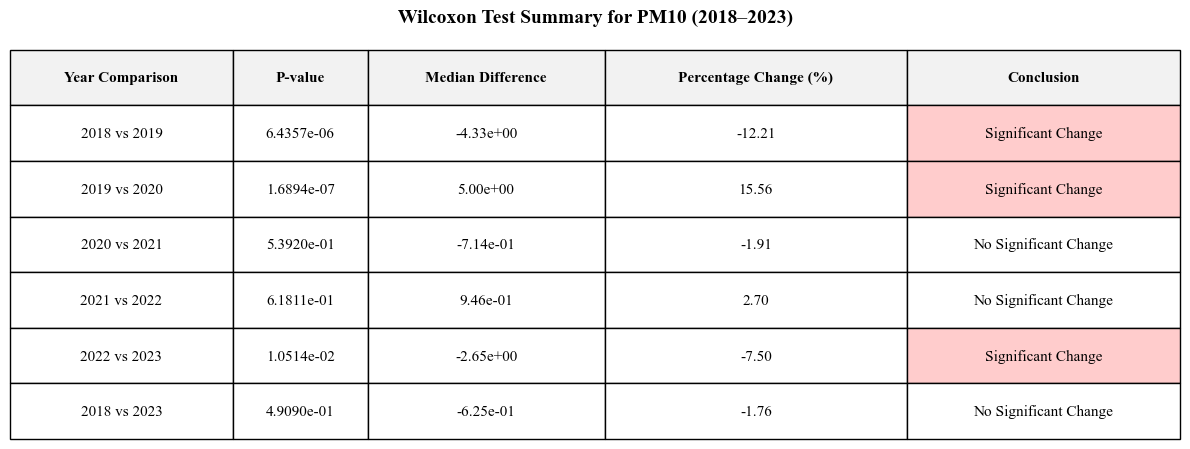

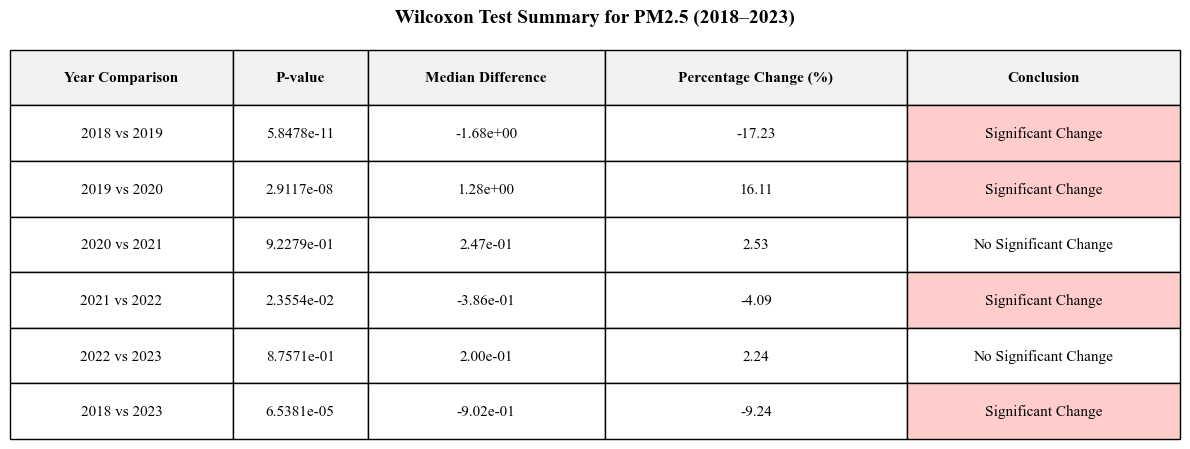

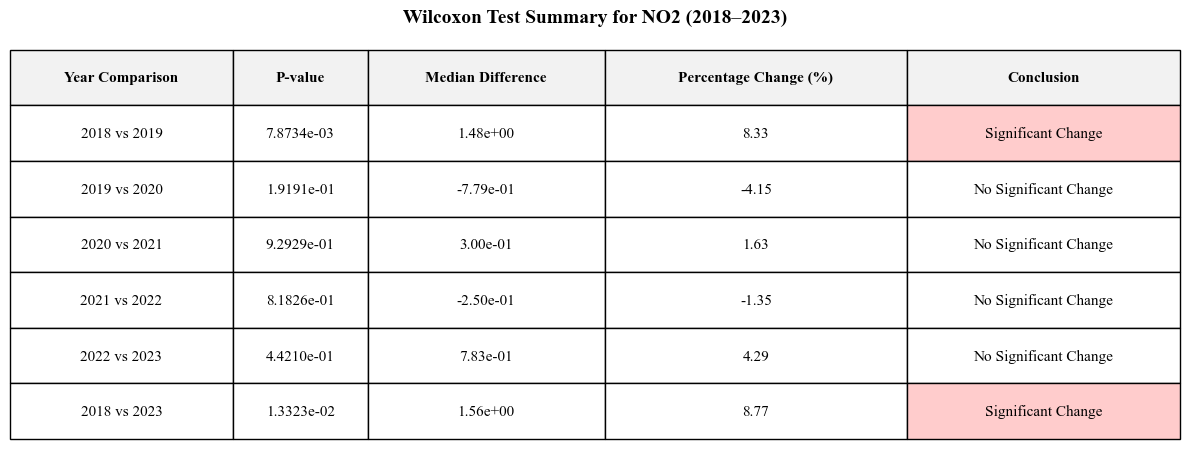

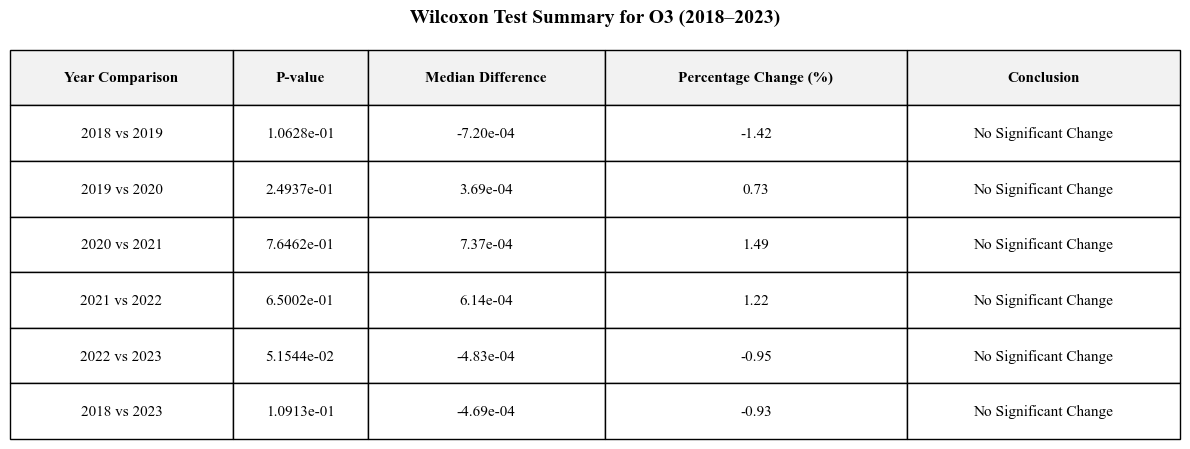

In [16]:
for pollutant, df in all_results.items():
    plot_wilcoxon_table(df, pollutant)

## Visualizations

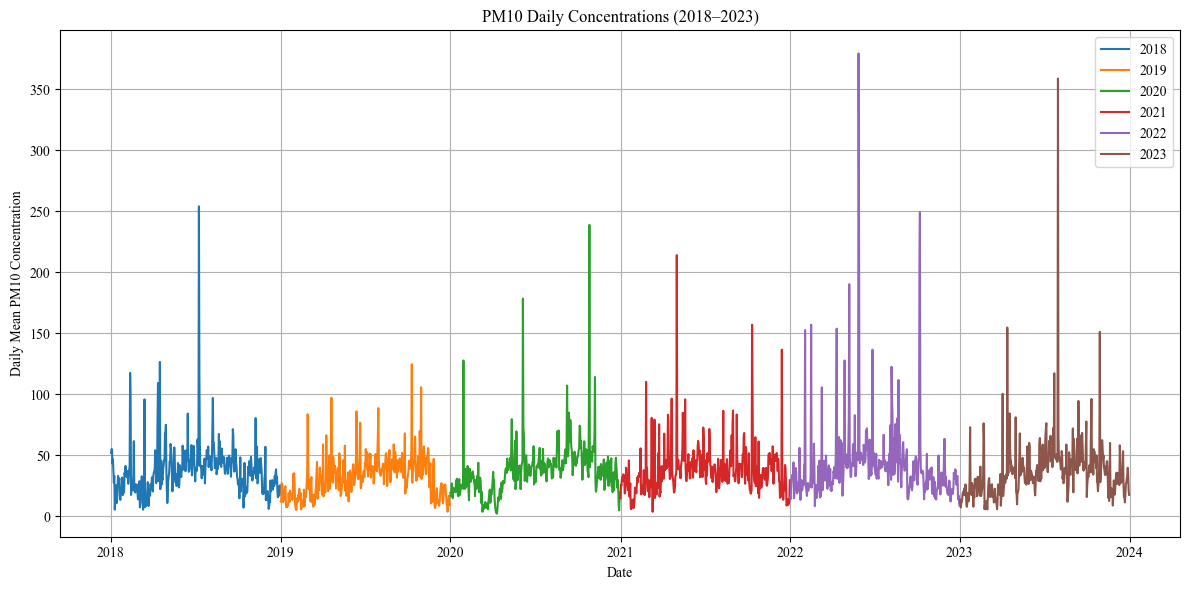

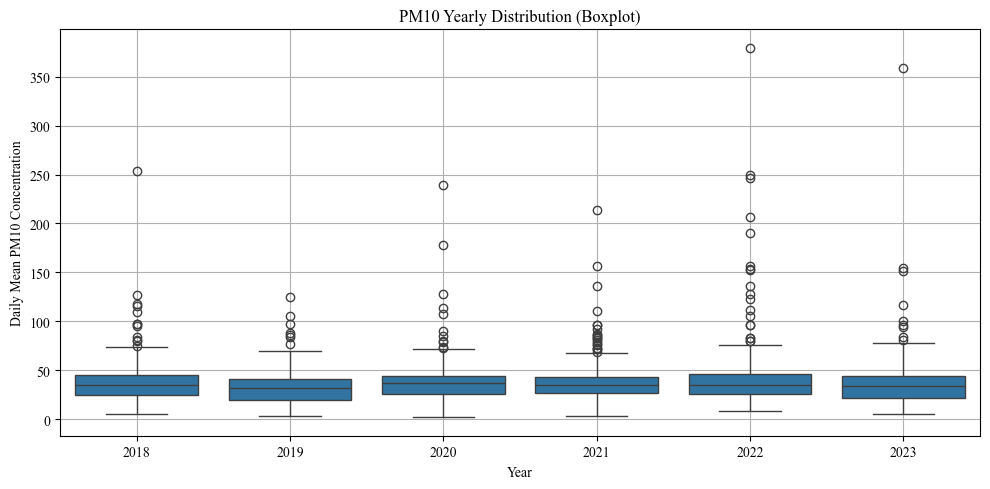

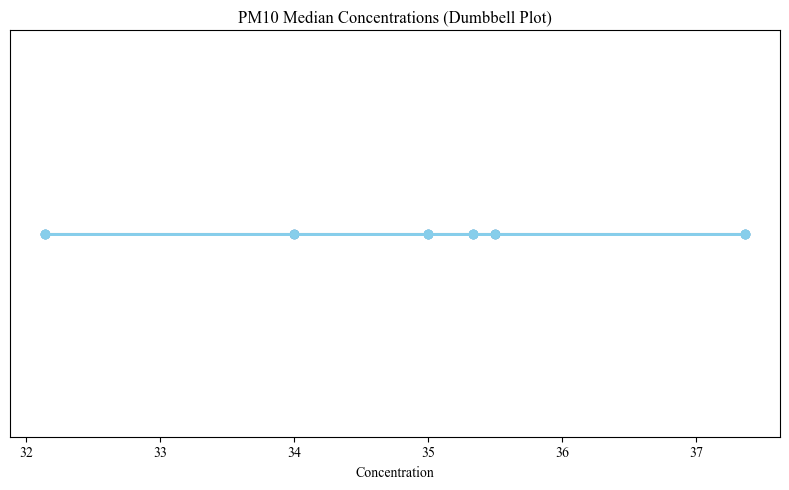

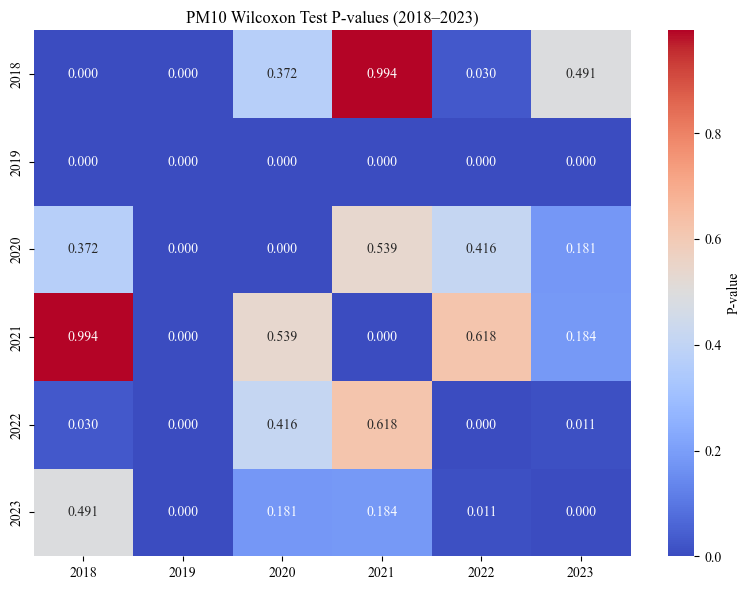

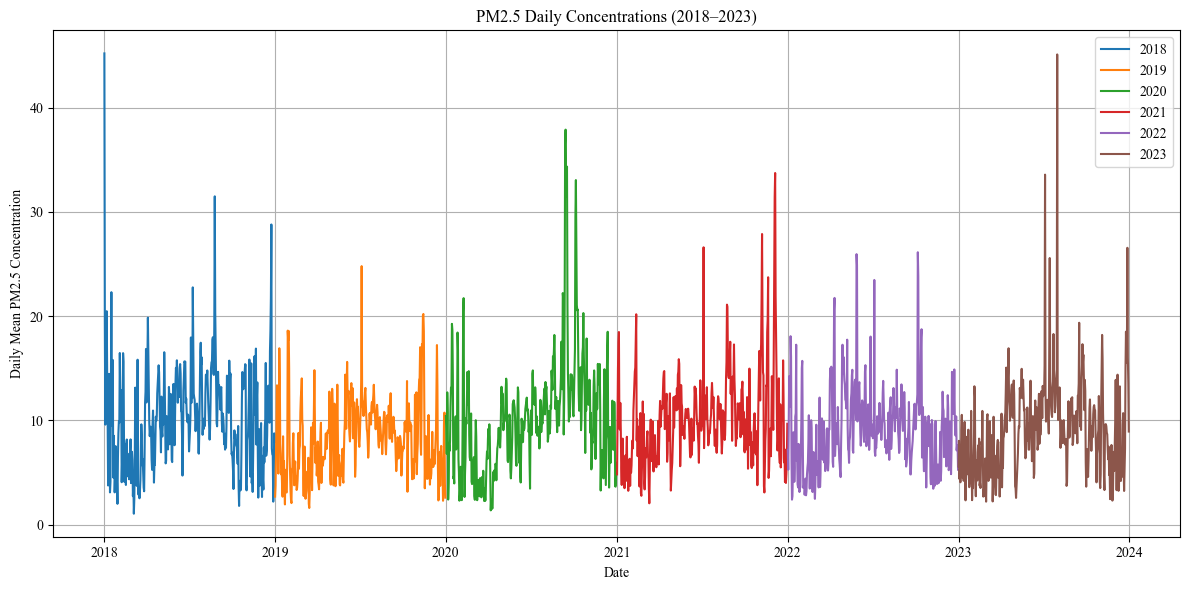

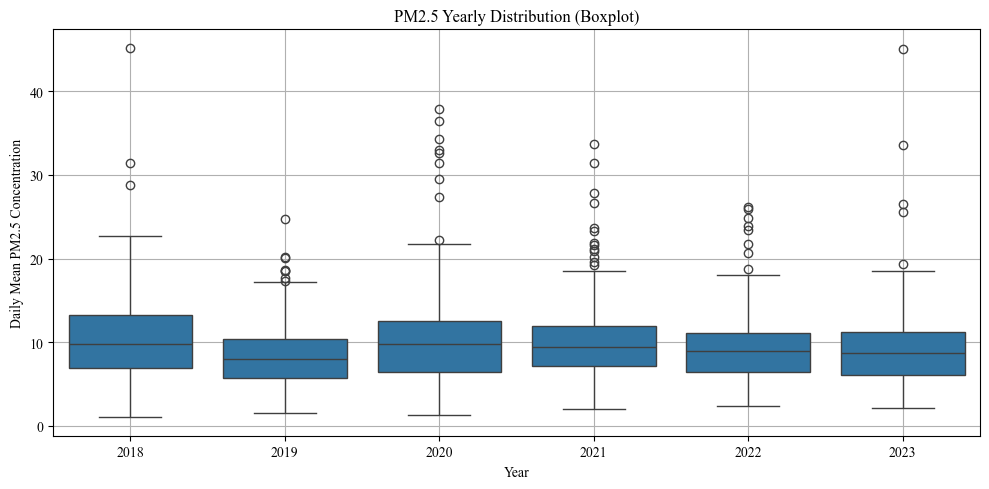

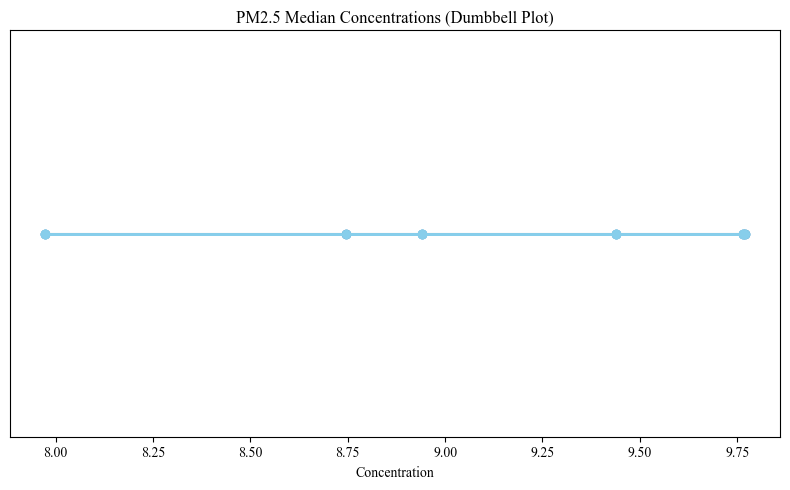

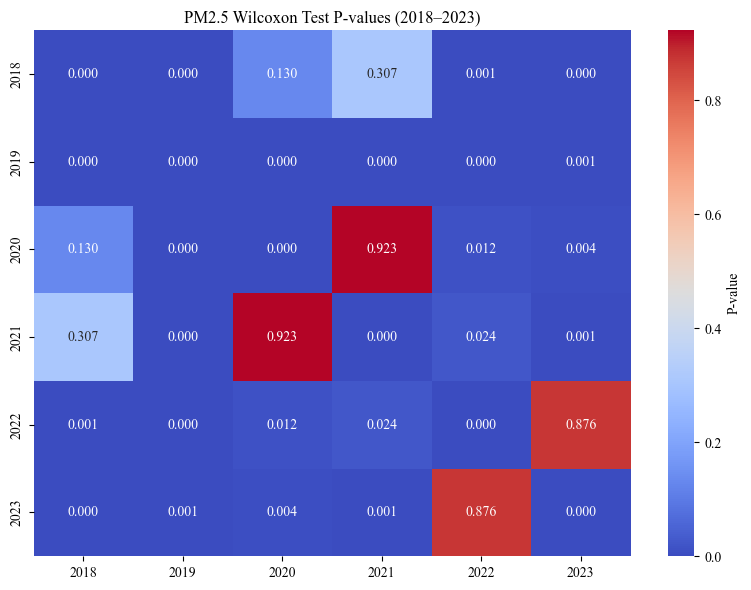

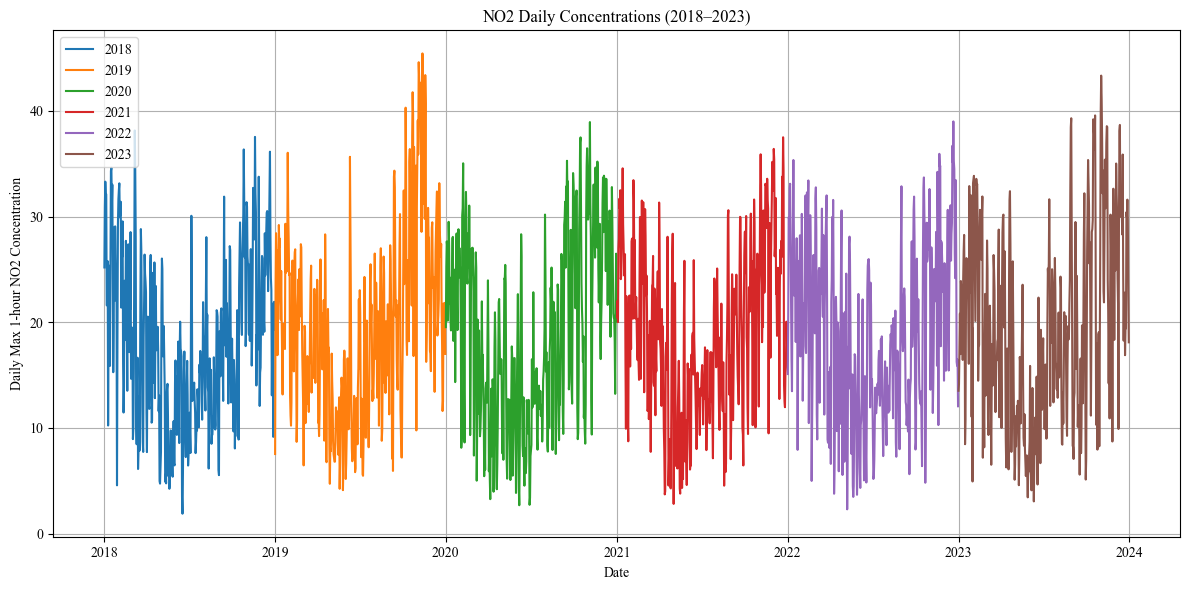

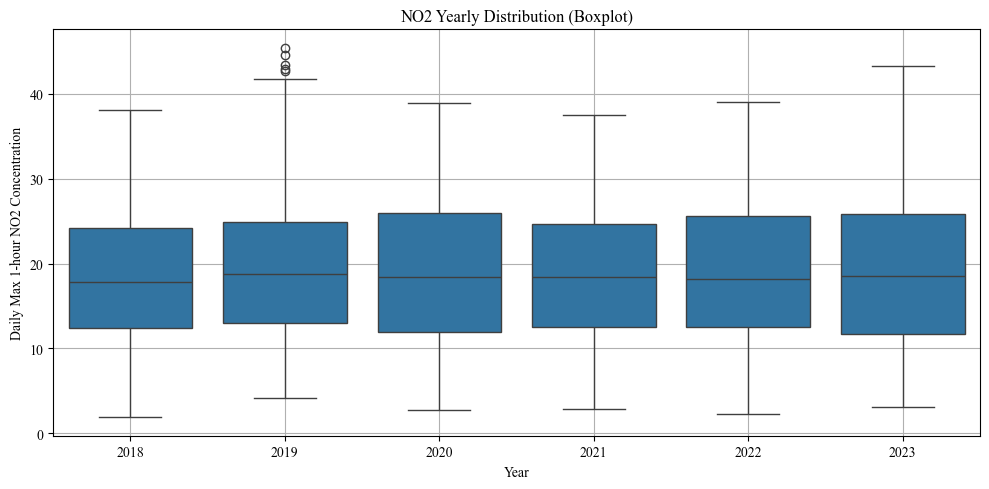

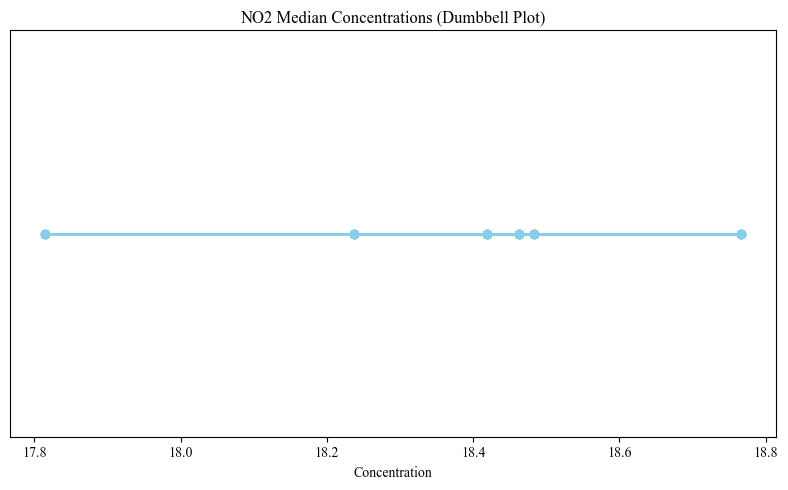

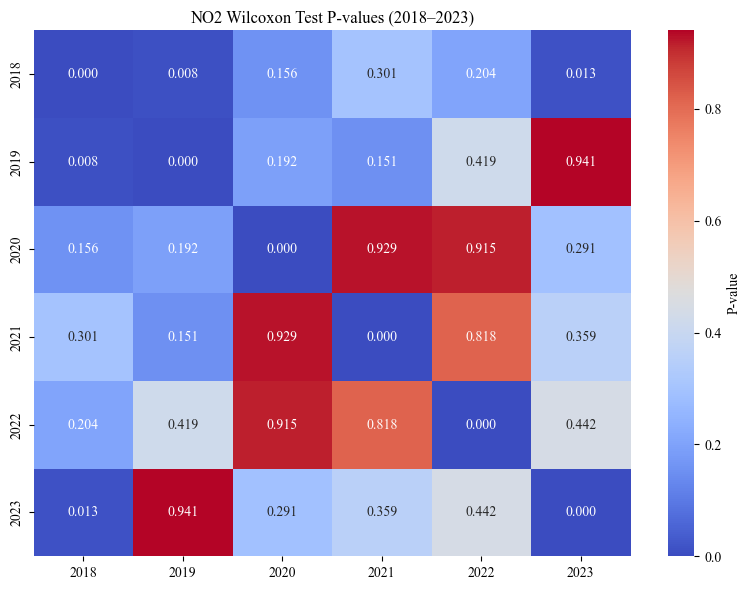

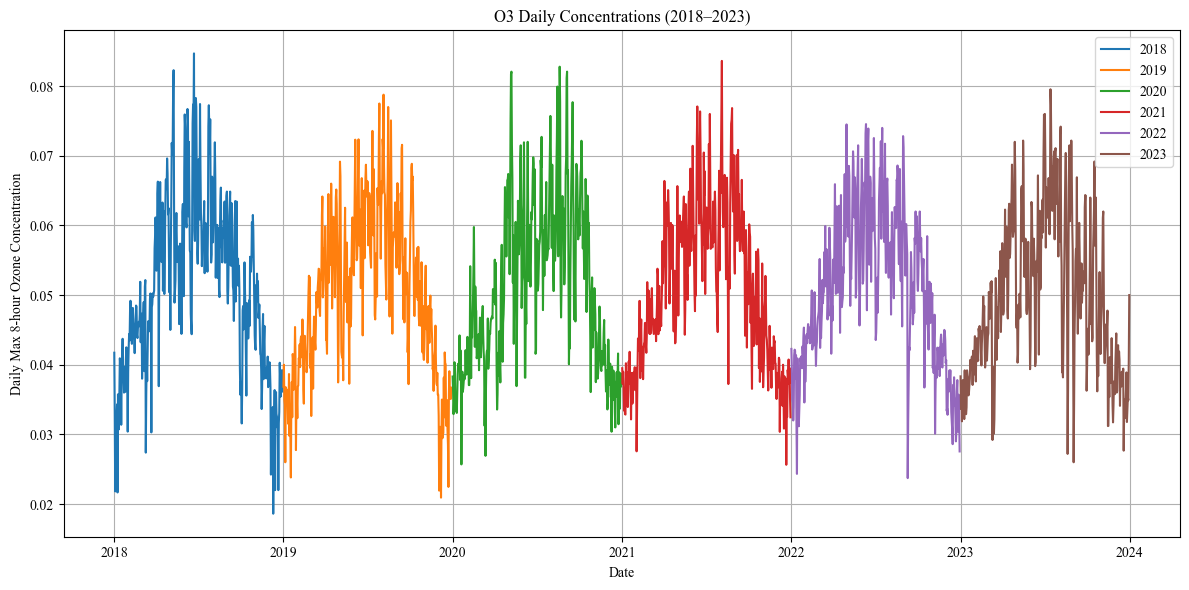

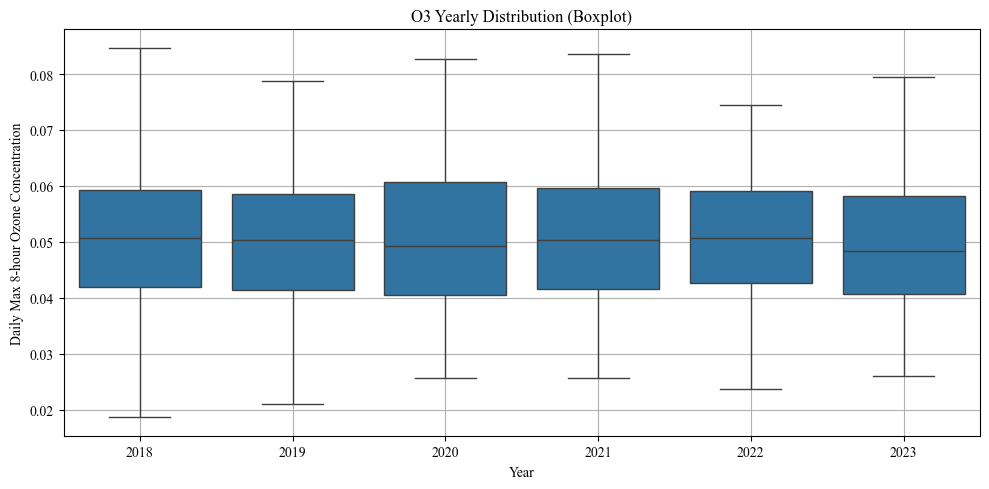

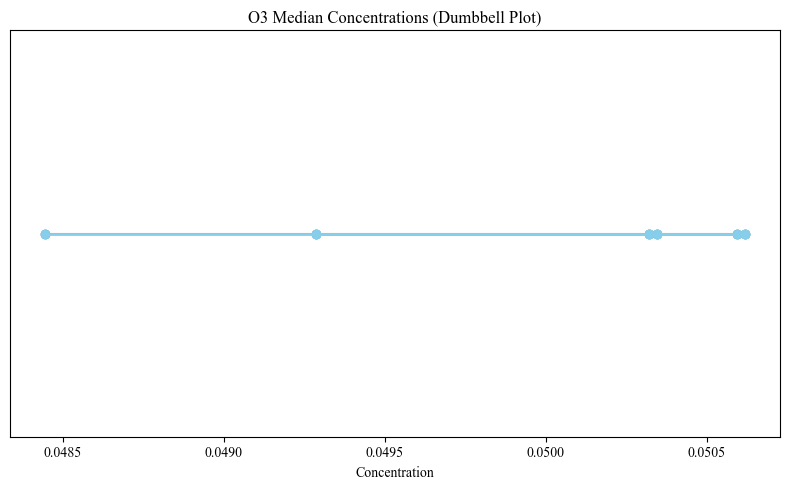

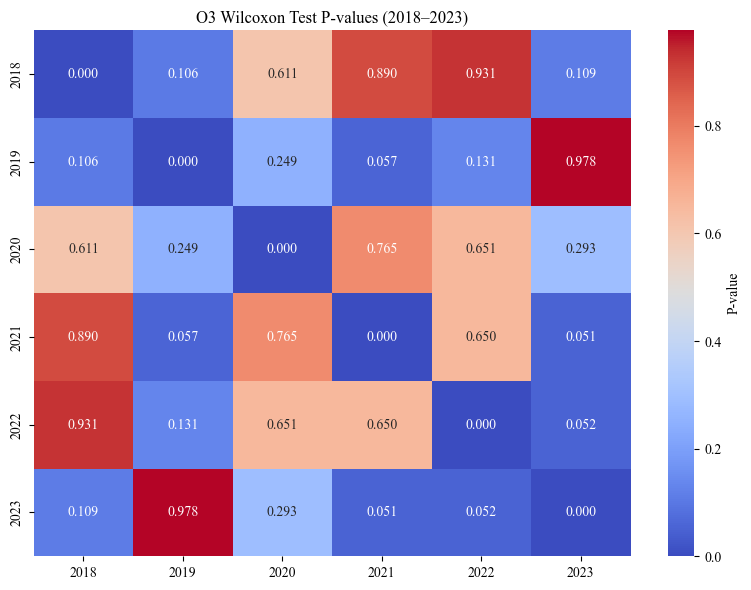

In [ ]:
# Setup
base_dir = "C:/Users/tle33/OneDrive/Desktop/ENGR296/data"
pollutants = {
    "PM10": {"folder": "PM10", "file_prefix": "PM10", "column": "Daily Mean PM10 Concentration"},
    "PM2.5": {"folder": "PM2.5", "file_prefix": "PM2.5", "column": "Daily Mean PM2.5 Concentration"},
    "NO2": {"folder": "NO2", "file_prefix": "NO2", "column": "Daily Max 1-hour NO2 Concentration"},
    "O3": {"folder": "O3", "file_prefix": "O3", "column": "Daily Max 8-hour Ozone Concentration"},
}
years = list(range(2018, 2024))

# Load and process data
all_data = {}
for pollutant, info in pollutants.items():
    yearly_data = []
    for year in years:
        file_path = os.path.join(base_dir, info["folder"], f"{info['file_prefix']}_{year}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, usecols=["Date", info["column"]])
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.groupby("Date")[info["column"]].mean().reset_index()
            df["Year"] = year
            df["Month-Day"] = df["Date"].dt.strftime("%m-%d")
            yearly_data.append(df)
        else:
            print(f"Missing file: {file_path}")
    
    if yearly_data:
        all_data[pollutant] = pd.concat(yearly_data, ignore_index=True)
    else:
        print(f"No data available for {pollutant}. Skipping...")
        continue

# Generate plots
for pollutant, df in all_data.items():
    value_col = pollutants[pollutant]["column"]

    #Time Series Plot
    plt.figure(figsize=(12, 6))
    for year in years:
        yearly_df = df[df["Year"] == year]
        plt.plot(yearly_df["Date"], yearly_df[value_col], label=str(year))
    plt.title(f"{pollutant} Daily Concentrations (2018–2023)")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #Yearly Boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x="Year", y=value_col)
    plt.title(f"{pollutant} Yearly Distribution (Boxplot)")
    plt.xlabel("Year")
    plt.ylabel(value_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #Dumbbell Plot for Medians
    median_df = df.groupby("Year")[value_col].median().reset_index()
    plt.figure(figsize=(8, 5))
    plt.hlines(1, median_df[value_col].min(), median_df[value_col].max(), color='gray', alpha=0.7)
    plt.plot(median_df[value_col], np.ones_like(median_df[value_col]), "o", label="Median")
    for i in range(len(median_df) - 1):
        plt.plot([median_df[value_col][i], median_df[value_col][i+1]], [1, 1],
                 marker="o", color="skyblue", linewidth=2)
    plt.title(f"{pollutant} Median Concentrations (Dumbbell Plot)")
    plt.xlabel("Concentration")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

    #Wilcoxon P-value Heatmap
    pivot_df = df.pivot(index="Month-Day", columns="Year", values=value_col).dropna()
    heatmap_data = pd.DataFrame(index=years, columns=years, dtype=float)
    for y1, y2 in itertools.combinations(years, 2):
        try:
            stat, p = wilcoxon(pivot_df[y1], pivot_df[y2])
            heatmap_data.loc[y1, y2] = p
            heatmap_data.loc[y2, y1] = p
        except:
            heatmap_data.loc[y1, y2] = np.nan
            heatmap_data.loc[y2, y1] = np.nan
    np.fill_diagonal(heatmap_data.values, 0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'P-value'})
    plt.title(f"{pollutant} Wilcoxon Test P-values (2018–2023)")
    plt.tight_layout()
    plt.show()


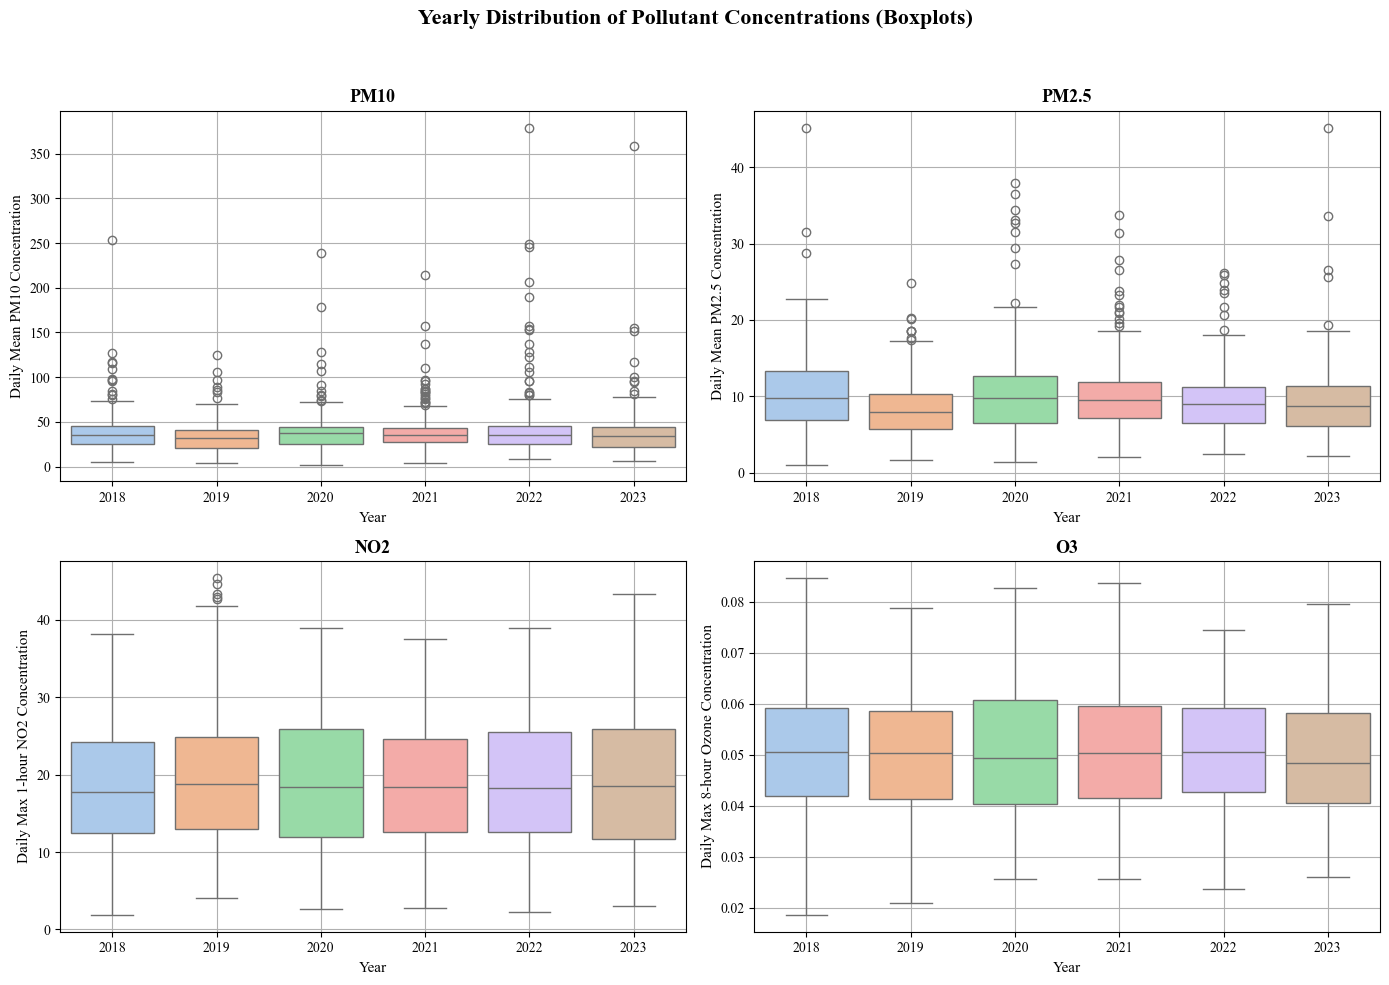

In [ ]:
# subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
fig.suptitle("Yearly Distribution of Pollutant Concentrations (Boxplots)", fontsize=16, fontweight="bold")

axes = axes.flatten()

# Plot settings
for idx, (pollutant, df) in enumerate(all_data.items()):
    ax = axes[idx]
    value_col = pollutants[pollutant]["column"]

    sns.boxplot(data=df, x="Year", y=value_col, hue="Year", ax=ax, palette="pastel", legend=False)
    ax.set_title(f"{pollutant}", fontsize=13, fontweight="bold")
    ax.set_xlabel("Year", fontsize=11)
    ax.set_ylabel(value_col, fontsize=11)
    ax.grid(True)

for j in range(len(all_data), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
